In [2]:
import yaml
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
from func import *
import geopandas as gpd
import matplotlib.pyplot as plt
import geodatasets

In [3]:
with open('../config/config.yaml', 'r') as f:
    config = yaml.load(f, Loader=yaml.SafeLoader)


## Efectivo en circulación

In [4]:
infoConsultasBilletes = {
    "SM1472": "https://www.banxico.org.mx/SieAPIRest/service/v1/series/SM1472",
    "SM1478": "https://www.banxico.org.mx/SieAPIRest/service/v1/series/SM1478",
    "SM1479": "https://www.banxico.org.mx/SieAPIRest/service/v1/series/SM1479",
    "SM1480": "https://www.banxico.org.mx/SieAPIRest/service/v1/series/SM1480",
    "SM1481": "https://www.banxico.org.mx/SieAPIRest/service/v1/series/SM1481",
    "SM1482": "https://www.banxico.org.mx/SieAPIRest/service/v1/series/SM1482"
    }
infoConsultasMonedas = {
    "SM13": "https://www.banxico.org.mx/SieAPIRest/service/v1/series/SM13",
    "SM14": "https://www.banxico.org.mx/SieAPIRest/service/v1/series/SM14",
    "SM15": "https://www.banxico.org.mx/SieAPIRest/service/v1/series/SM15",
    "SM16": "https://www.banxico.org.mx/SieAPIRest/service/v1/series/SM16"}

In [5]:
dfBilletes = pd.DataFrame()
Valores = dict()
for key in infoConsultasBilletes.keys():
    title, df_query = consultaTotalBilletesMonedas(key=key,
                                        infoConsultas=infoConsultasBilletes,
                                        config=config)
    clave = " ".join(title.split(" ")[-2:])
    valor = int(title.split(" ")[-2].replace(',', ''))
    Valores[clave] = valor
    dfBilletes = pd.merge(left=dfBilletes,
                  right=df_query,
                  left_index=True,
                  right_index=True,
                  how="outer")

In [6]:
    
dfMonedas = pd.DataFrame()
for key in infoConsultasMonedas.keys():
    title, df_query = consultaTotalBilletesMonedas(key=key,
                                        infoConsultas=infoConsultasMonedas,
                                        config=config)
    clave = " ".join(title.split(" ")[-2:])
    valor = int(title.split(" ")[-2].replace(',', ''))
    Valores[clave] = valor
    dfMonedas = pd.merge(left=dfMonedas,
                  right=df_query,
                  left_index=True,
                  right_index=True,
                  how="outer")

In [7]:
minDate =pd.to_datetime(config["minDate"], format="%d-%m-%Y")

df = pd.merge(left=dfMonedas,
         right=dfBilletes,
         left_index=True,
         right_index=True,
         how="outer")

df = df[df.index >= minDate]

In [8]:
df_copy = df.copy()
for key in df.columns:
    df_copy[key] = df_copy[key]*1e6*Valores[key]

totalCirculacion = pd.DataFrame(df_copy.sum(axis=1), columns=["Total"])

## Inflación

* INPC: Indice Nacional de Precios al Consumidor
* Año base
* Billon (En): Mil millones <1e9>
* Billon (Es): Millon de millones <1e12> 

In [ ]:
inflacionHistorica = {
    "Mensual": f"https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/910399/es/0700/false/BIE/2.0/{config['INEGI_token']}?type=json",
    "Quincenal": f"https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/910399,910427/es/0700/false/BIE/2.0/{config['INEGI_token']}?type=json"
}

In [10]:
Periodo = "Mensual"
df_inpc = INPC_historico(inflacionHistorica=inflacionHistorica, Periodo=Periodo, min_date=minDate)
inflacion = dict()
for date in df_inpc.index:
    df_aux = df_inpc.loc[:date,:]
    factores = (1 + df_aux[f'Inflacion_{Periodo}'] / 100)
    inflacion_acumulada = (factores.prod() - 1) * 100
    inflacion[date] = np.round(inflacion_acumulada,2)
df_inflacion = pd.DataFrame.from_dict(data=inflacion,orient="index", columns=["Inflacion"])
df_inflacion.index.name = "fecha"

In [11]:
# Crear figura
fig = go.Figure()

# Agregar la primera serie (eje Y principal)
fig.add_trace(go.Scatter(x=totalCirculacion.index, y=totalCirculacion.Total/1e9, name='Flujo (Miles MdP)', yaxis='y1'))

# Agregar la segunda serie (eje Y secundario)
fig.add_trace(go.Scatter(x=df_inflacion.index, y=df_inflacion.Inflacion, name='Inflación (%)', yaxis='y2'))

# Configurar layout con ejes dobles
fig.update_layout(
    title='Inflación vs dinero en circulación en México',
    xaxis=dict(title='Fecha'),
    yaxis=dict(title='Total flujo en efectivo'),
    yaxis2=dict(title='Inflación', overlaying='y', side='right'),
    legend=dict(x=0.01, y=0.99)
)

fig.show()

In [12]:
df = pd.merge(left=df_inflacion, right=totalCirculacion, left_index=True, right_index=True)

In [13]:
df.corr(method="spearman")

,Inflacion,Total
Inflacion,1.000000,0.997075
Total,0.997075,1.000000


##  Precios en México

In [48]:
mex = gpd.read_file("../data/mx.json")
dF_Edos = mex["id"]
df_Edos = mex[["name", "id"]].sort_values("name").reset_index()\
    .drop(columns=["index"]).reset_index().rename(columns={"index":"idNum"})
df_Edos["idNum"] = df_Edos["idNum"] +1 + 7000000
df_Edos["INEGI_id"] = df_Edos.idNum.apply(lambda x: "0" + str(x))
diccionario = dict(zip(df_Edos['id'], df_Edos['INEGI_id']))
mex

,source,id,name,geometry
0,https://simplemaps.com,MXSON,Sonora,"MULTIPOLYGON (((-114.81937 32.49936, -114.8167..."
1,https://simplemaps.com,MXBCN,Baja California,"MULTIPOLYGON (((-114.81937 32.49936, -114.8194..."
2,https://simplemaps.com,MXCHH,Chihuahua,"POLYGON ((-108.46646 26.97987, -108.47317 26.9..."
3,https://simplemaps.com,MXCOA,Coahuila,"POLYGON ((-103.62726 26.64393, -103.64191 26.7..."
4,https://simplemaps.com,MXTAM,Tamaulipas,"MULTIPOLYGON (((-99.71067 27.67012, -99.70569 ..."
5,https://simplemaps.com,MXNLE,Nuevo León,"POLYGON ((-100.82844 24.56496, -100.81655 24.6..."
6,https://simplemaps.com,MXROO,Quintana Roo,"MULTIPOLYGON (((-89.14634 17.95146, -89.15409 ..."
7,https://simplemaps.com,MXCAM,Campeche,"MULTIPOLYGON (((-89.41536 19.65105, -89.37387 ..."
8,https://simplemaps.com,MXTAB,Tabasco,"POLYGON ((-92.48614 18.64848, -92.47587 18.631..."
9,https://simplemaps.com,MXCHP,Chiapas,"MULTIPOLYGON (((-93.5895 17.37553, -93.57596 1..."


|Evento | URL |
|-------|-----|
|Tasa de prevalencia delictiva por cada cien mil habitantes de 18 años y más |    https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/6200002197/es/07000001/true/BISE/2.0/[Aquí va tu Token]?type=json|
|Presuntos delitos registrados como abuso sexual en las intervenciones de la policía estatal (fuero común) |   https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/6200002197,6200001281/es/07000001/true/BISE/2.0/[Aquí va tu Token]?type=json|

 https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/[Catalogo]/[IdCatalogo]/[Idioma]/[Fuente de datos]/[Token]?type=[Formato]

 f" https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/{Catalogo}/{IdCatalogo}/{Idioma}/true/BISE/2.0/{Token}?type=[Formato]"

In [ ]:
prevalenciaDelictivaAgs  = f"https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/6200002197/es/07000001/true/BISE/2.0/{config['INEGI_token']}?type=json|"
prevalenciaDelictivaBC   = f"https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/6200002197/es/07000002/true/BISE/2.0/[Aquí va tu Token]?type=json"
prevalenciaDelictivaBC   = f"https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/6200002197/es/07000003/true/BISE/2.0/[Aquí va tu Token]?type=json"
presuntosDelitosSexAgs   = f" https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/6200002197,6200001281/es/07000001/true/BISE/2.0/[Aquí va tu Token]?type=json|"

'https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/6200002197/es/07000001/true/BISE/2.0/4a8acf7b-976e-d0df-8ee7-6c9f69242a91?type=json|'

In [ ]:
Catalogo = "INDICATOR"
Catalogos =  {"prevalenciaDelictiva": "6200002197",
              "presDelitosSexuales": "6200002197,6200001281"}
Token = config["INEGI_token"]
estado
IdCatalogo = Catalogos["prevalenciaDelictiva"]
url = f" https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/{Catalogo}/{IdCatalogo}/es/{}/true/BISE/2.0/{Token}?type=[Formato]"
url

' https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/6200002197/es/true/BISE/2.0/4a8acf7b-976e-d0df-8ee7-6c9f69242a91?type=[Formato]'

In [44]:
diccionario

{'MXAGU': '07000001',
 'MXBCN': '07000002',
 'MXBCS': '07000003',
 'MXCAM': '07000004',
 'MXCHP': '07000005',
 'MXCHH': '07000006',
 'MXCMX': '07000007',
 'MXCOA': '07000008',
 'MXCOL': '07000009',
 'MXDUR': '07000010',
 'MXGUA': '07000011',
 'MXGRO': '07000012',
 'MXHID': '07000013',
 'MXJAL': '07000014',
 'MXMIC': '07000015',
 'MXMOR': '07000016',
 'MXMEX': '07000017',
 'MXNAY': '07000018',
 'MXNLE': '07000019',
 'MXOAX': '07000020',
 'MXPUE': '07000021',
 'MXQUE': '07000022',
 'MXROO': '07000023',
 'MXSLP': '07000024',
 'MXSIN': '07000025',
 'MXSON': '07000026',
 'MXTAB': '07000027',
 'MXTAM': '07000028',
 'MXTLA': '07000029',
 'MXVER': '07000030',
 'MXYUC': '07000031',
 'MXZAC': '07000032'}

In [ ]:

# diccionario

In [ ]:
# prevalenciaDelictiva
"https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/6200002197/es/07000001/true/BISE/2.0/{config['INEGI_token']}?type=json|"

<Axes: >

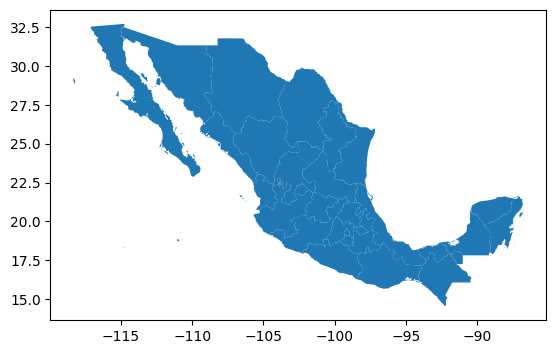

In [16]:
mex.set_index("name")[["geometry"]].plot()